# Implementation test

In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataset import IAMLinesDataset, IAMLinesDatasetPyTorch
import importlib


In [36]:
# Configuration
class Config:
    def __init__(self):
        # Dataset parameters
        self.img_size = (64, 256)  # Height, Width - Adjusted for line-level segments
        self.batch_size = 64
        self.num_workers = 4
        
        # VAE parameters
        self.latent_dim = 512  # Latent dimension for the VAE
        self.vae_lr = 1e-4
        self.vae_epochs = 2 #orig: 50
        
        # Diffusion model parameters
        self.timesteps = 1000  # Number of diffusion steps
        self.beta_start = 1e-4  # Starting noise schedule value
        self.beta_end = 2e-2  # Ending noise schedule value
        self.diffusion_lr = 1e-4
        self.diffusion_epochs = 5 #orig: 100
        
        # Style and content encoder parameters
        self.style_dim = 256
        self.content_dim = 256
        
        # Training parameters
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
            print("Using mac gpu")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
            print("Using cuda gpu")
        else:
            self.device = torch.device("cpu")
            print("Using cpu")
        self.save_dir = "./models"
        self.results_dir = "./results"
        
        # Create directories if they don't exist
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)

In [37]:
# Dataset and preprocessing
class IAMDatasetWrapper:
    def __init__(self, config):
        self.config = config
        self.transform = transforms.Compose([
            transforms.Resize(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
        ])
        
    def setup(self):
        """Load the IAM dataset and create train/val/test splits"""
        print("Loading IAM dataset...")
        # Assuming IAMLinesDatasetPyTorch is already implemented
        data_path = 'data/lines.tgz' 
        xml_path = 'data/xml.tgz'    
        iam_dataset = IAMLinesDataset(data_path, xml_path)
        full_dataset = IAMLinesDatasetPyTorch(iam_dataset=iam_dataset, transform=self.transform)
        
        # Split into train/val/test
        train_size = int(0.8 * len(full_dataset))
        val_size = int(0.1 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        
        train_dataset, val_dataset, test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )
        
        self.train_loader = DataLoader(
            train_dataset, 
            batch_size=self.config.batch_size, 
            shuffle=True,
            num_workers=self.config.num_workers
        )
        
        self.val_loader = DataLoader(
            val_dataset, 
            batch_size=self.config.batch_size, 
            shuffle=False,
            num_workers=self.config.num_workers
        )
        
        self.test_loader = DataLoader(
            test_dataset, 
            batch_size=self.config.batch_size, 
            shuffle=False,
            num_workers=self.config.num_workers
        )
        
        print(f"Dataset loaded. Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
        return self.train_loader, self.val_loader, self.test_loader


In [38]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, config):
        super(VAE, self).__init__()
        self.config = config
        self.latent_dim = config.latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        
        # Calculate the size of the encoder output
        h, w = config.img_size
        self.encoder_output_size = (h // 16, w // 16, 256)
        self.encoder_flattened_dim = self.encoder_output_size[0] * self.encoder_output_size[1] * self.encoder_output_size[2]
        
        # Mean and log variance layers
        self.fc_mu = nn.Linear(self.encoder_flattened_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_flattened_dim, self.latent_dim)
        
        # Decoder input layer
        self.decoder_input = nn.Linear(self.latent_dim, self.encoder_flattened_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 256, self.encoder_output_size[0], self.encoder_output_size[1])
        x_recon = self.decoder(z)
        return x_recon
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Style Encoder
class StyleEncoder(nn.Module):
    def __init__(self, config):
        super(StyleEncoder, self).__init__()
        self.config = config
        
        # CNN backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Projection head
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, config.style_dim)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten
        style = self.fc(x)
        return style

# Content Encoder (for text)
class ContentEncoder(nn.Module):
    def __init__(self, config, vocab_size=128, embedding_dim=128):
        super(ContentEncoder, self).__init__()
        self.config = config
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Projection head
        self.fc = nn.Linear(512, config.content_dim)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len]
        embedded = self.embedding(x)
        
        # LSTM forward pass
        output, (hidden, _) = self.lstm(embedded)
        
        # Concatenate forward and backward hidden states
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        
        # Project to content dimension
        content = self.fc(hidden)
        return content

# Diffusion Model
class LatentDiffusionModel:
    def __init__(self, config):
        self.config = config
        self.device = config.device
        
        # Define beta schedule
        self.beta = torch.linspace(config.beta_start, config.beta_end, config.timesteps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        
        # Initialize models
        self.vae = VAE(config).to(self.device)
        self.style_encoder = StyleEncoder(config).to(self.device)
        self.content_encoder = ContentEncoder(config).to(self.device)
        self.diffusion_model = DiffusionUNet(config).to(self.device)
        
        # Define optimizers
        self.vae_optimizer = optim.Adam(self.vae.parameters(), lr=config.vae_lr)
        self.style_optimizer = optim.Adam(self.style_encoder.parameters(), lr=config.diffusion_lr)
        self.content_optimizer = optim.Adam(self.content_encoder.parameters(), lr=config.diffusion_lr)
        self.diffusion_optimizer = optim.Adam(self.diffusion_model.parameters(), lr=config.diffusion_lr)
    
    def train_vae(self, train_loader, val_loader, epochs=None):
        """Train the VAE model"""
        if epochs is None:
            epochs = self.config.vae_epochs
        
        print("Training VAE...")
        
        for epoch in range(epochs):
            self.vae.train()
            train_loss = 0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                self.vae_optimizer.zero_grad()
                
                # Get handwriting images
                images = batch['image'].to(self.device)
                
                # Forward pass
                recon_images, mu, logvar = self.vae(images)
                
                # Compute loss
                recon_loss = F.mse_loss(recon_images, images)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + 0.001 * kl_loss
                
                # Backward pass
                loss.backward()
                self.vae_optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            
            # Validation
            val_loss = self._validate_vae(val_loader)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            # Save checkpoint
            if (epoch + 1) % 10 == 0:
                self._save_checkpoint(f"vae_epoch_{epoch+1}.pt", model=self.vae)
        
        print("VAE training completed.")
    
    def _validate_vae(self, val_loader):
        """Validate the VAE model"""
        self.vae.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(self.device)
                
                # Forward pass
                recon_images, mu, logvar = self.vae(images)
                
                # Compute loss
                recon_loss = F.mse_loss(recon_images, images)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + 0.001 * kl_loss
                
                val_loss += loss.item()
        
        return val_loss / len(val_loader)
    
    def train_diffusion(self, train_loader, val_loader, epochs=None):
        """Train the diffusion model"""
        if epochs is None:
            epochs = self.config.diffusion_epochs
        
        print("Training Diffusion Model...")
        
        # Ensure VAE is in eval mode and frozen
        self.vae.eval()
        for param in self.vae.parameters():
            param.requires_grad = False
        
        # Calculate latent dimensions for clarity
        latent_h = self.config.img_size[0] // 16  # Height divided by total downsampling factor
        latent_w = self.config.img_size[1] // 16  # Width divided by total downsampling factor
        latent_channels = 256  # Number of channels in the VAE bottleneck
        
        for epoch in range(epochs):
            # Training
            self.diffusion_model.train()
            self.style_encoder.train()
            self.content_encoder.train()
            
            train_loss = 0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                # Zero gradients
                self.diffusion_optimizer.zero_grad()
                self.style_optimizer.zero_grad()
                self.content_optimizer.zero_grad()
                
                # Get data
                images = batch['image'].to(self.device)
                text = batch['transcription']
                
                # Process text data - create proper tokenization
                # For simplicity, using a fixed length and padding
                max_seq_len = 100
                text_indices = torch.zeros(len(text), max_seq_len).long().to(self.device)
                for i, t in enumerate(text):
                    # Convert string to character indices (simplified)
                    # In production, use a proper tokenizer
                    for j, char in enumerate(t[:max_seq_len]):
                        text_indices[i, j] = ord(char) % 128  # Simple char to index mapping
                
                # Extract spatial latent representations from the VAE
                with torch.no_grad():
                    # Get encoder outputs
                    encoder_output = self.vae.encoder(images)
                    # Flatten for mu/logvar calculation
                    encoder_flat = encoder_output.view(images.shape[0], -1)
                    # Get latent distribution parameters
                    mu = self.vae.fc_mu(encoder_flat)
                    logvar = self.vae.fc_logvar(encoder_flat)
                    # Sample from distribution
                    z_flat = self.vae.reparameterize(mu, logvar)
                    
                    # Map back to spatial representation
                    z_projected = self.vae.decoder_input(z_flat)
                    # Reshape to spatial dimensions expected by diffusion model
                    # [batch_size, channels, height, width]
                    latent_spatial = z_projected.view(
                        images.shape[0],
                        latent_channels,
                        latent_h,
                        latent_w
                    )
                
                # Sample random timesteps for each image
                t = torch.randint(0, self.config.timesteps, (images.shape[0],), device=self.device)
                
                # Add noise to latent images
                noise = torch.randn_like(latent_spatial)
                alpha_cumprod_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
                
                # Calculate noisy latents
                noisy_latents = torch.sqrt(alpha_cumprod_t) * latent_spatial + torch.sqrt(1 - alpha_cumprod_t) * noise
                
                # Encode style and content
                style_features = self.style_encoder(images)
                content_features = self.content_encoder(text_indices)
                
                # Predict noise using the diffusion UNet
                noise_pred = self.diffusion_model(noisy_latents, t, style_features, content_features)
                
                # Compute loss between predicted and actual noise
                loss = F.mse_loss(noise_pred, noise)
                
                # Backward pass
                loss.backward()
                
                # Apply gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.diffusion_model.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(self.style_encoder.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(self.content_encoder.parameters(), max_norm=1.0)
                
                # Update parameters
                self.diffusion_optimizer.step()
                self.style_optimizer.step()
                self.content_optimizer.step()
                
                train_loss += loss.item()
            
            # Calculate average training loss
            train_loss /= len(train_loader)
            
            # Validation after each epoch
            val_loss = self._validate_diffusion(val_loader)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            # Save checkpoint
            if (epoch + 1) % 5 == 0 or epoch == epochs - 1:  # Save more frequently
                self._save_checkpoint(
                    f"diffusion_epoch_{epoch+1}.pt", 
                    models=[self.diffusion_model, self.style_encoder, self.content_encoder]
                )
        
        print("Diffusion model training completed!")
    
    def _validate_diffusion(self, val_loader):
        """Validate the diffusion model"""
        # Set models to evaluation mode
        self.diffusion_model.eval()
        self.style_encoder.eval()
        self.content_encoder.eval()
        
        val_loss = 0
        num_batches = 0
        
        # Calculate latent dimensions
        latent_h = self.config.img_size[0] // 16
        latent_w = self.config.img_size[1] // 16
        latent_channels = 256
        
        with torch.no_grad():
            for batch in val_loader:
                # Get data
                images = batch['image'].to(self.device)
                text = batch['transcription']
                
                # Process text data
                max_seq_len = 100
                text_indices = torch.zeros(len(text), max_seq_len).long().to(self.device)
                for i, t in enumerate(text):
                    for j, char in enumerate(t[:max_seq_len]):
                        text_indices[i, j] = ord(char) % 128
                
                # Extract spatial latents from VAE
                encoder_output = self.vae.encoder(images)
                encoder_flat = encoder_output.view(images.shape[0], -1)
                mu = self.vae.fc_mu(encoder_flat)
                logvar = self.vae.fc_logvar(encoder_flat)
                z_flat = self.vae.reparameterize(mu, logvar)
                
                # Map to spatial representation
                z_projected = self.vae.decoder_input(z_flat)
                latent_spatial = z_projected.view(
                    images.shape[0], 
                    latent_channels,
                    latent_h,
                    latent_w
                )
                
                # Sample random timesteps
                t = torch.randint(0, self.config.timesteps, (images.shape[0],), device=self.device)
                
                # Add noise to latents
                noise = torch.randn_like(latent_spatial)
                alpha_cumprod_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
                noisy_latents = torch.sqrt(alpha_cumprod_t) * latent_spatial + torch.sqrt(1 - alpha_cumprod_t) * noise
                
                # Get style and content features
                style_features = self.style_encoder(images)
                content_features = self.content_encoder(text_indices)
                
                # Predict noise
                noise_pred = self.diffusion_model(noisy_latents, t, style_features, content_features)
                
                # Compute loss
                loss = F.mse_loss(noise_pred, noise)
                
                val_loss += loss.item()
                num_batches += 1
        
        return val_loss / num_batches
    
    def _save_checkpoint(self, filename, model=None, models=None):
        """Save model checkpoint"""
        save_path = os.path.join(self.config.save_dir, filename)
        
        if model is not None:
            torch.save(model.state_dict(), save_path)
        elif models is not None:
            save_dict = {}
            for i, m in enumerate(models):
                save_dict[f"model_{i}"] = m.state_dict()
            torch.save(save_dict, save_path)
    
    # def generate_handwriting(self, style_image, text, steps=50):
    #     """Generate handwriting with a given style and text"""
    #     # Ensure models are in eval mode
    #     self.vae.eval()
    #     self.style_encoder.eval()
    #     self.content_encoder.eval()
    #     self.diffusion_model.eval()
        
    #     with torch.no_grad():
    #         # Preprocess style image
    #         style_image = style_image.unsqueeze(0).to(self.device)
            
    #         # Encode style
    #         style_features = self.style_encoder(style_image)
            
    #         # Encode text (simplified)
    #         text_indices = torch.zeros(1, 100).long().to(self.device)  # Placeholder
    #         content_features = self.content_encoder(text_indices)
            
    #         # Start with random noise in the latent space
    #         latent_shape = (1, 256, self.config.img_size[0] // 16, self.config.img_size[1] // 16)
    #         latent = torch.randn(latent_shape).to(self.device)
            
    #         # Denoise gradually
    #         for t in tqdm(range(self.config.timesteps - 1, -1, -1), desc="Generating"):
    #             # Get the timestep
    #             timestep = torch.tensor([t], device=self.device)
                
    #             # Predict noise
    #             noise_pred = self.diffusion_model(latent, timestep, style_features, content_features)
                
    #             # Get alpha values for current timestep
    #             alpha = self.alpha[t]
    #             alpha_cumprod = self.alpha_cumprod[t]
    #             beta = self.beta[t]
                
    #             # No noise at timestep 0
    #             if t > 0:
    #                 noise = torch.randn_like(latent)
    #             else:
    #                 noise = torch.zeros_like(latent)
                
    #             # Update latent
    #             latent = (1 / torch.sqrt(alpha)) * (
    #                 latent - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * noise_pred
    #             ) + torch.sqrt(beta) * noise
            
    #         # Decode latent to image
    #         generated_image = self.vae.decode(latent)
            
    #         return generated_image
    def generate_handwriting(self, style_image, text, steps=None):
        """Generate handwriting with a given style and text"""
        if steps is None:
            steps = self.config.timesteps
        
        # Ensure models are in eval mode
        self.vae.eval()
        self.style_encoder.eval()
        self.content_encoder.eval()
        self.diffusion_model.eval()
        
        # Calculate latent dimensions
        latent_h = self.config.img_size[0] // 16
        latent_w = self.config.img_size[1] // 16
        latent_channels = 256
        
        with torch.no_grad():
            # Preprocess style image
            if not isinstance(style_image, torch.Tensor):
                # Convert to tensor if needed (e.g., if it's a PIL image)
                transform = transforms.Compose([
                    transforms.Resize(self.config.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                ])
                style_image = transform(style_image).unsqueeze(0)
            
            style_image = style_image.to(self.device)
            
            # Encode style
            style_features = self.style_encoder(style_image)
            
            # Process text input
            max_seq_len = 100
            text_indices = torch.zeros(1, max_seq_len).long().to(self.device)
            for i, char in enumerate(text[:max_seq_len]):
                text_indices[0, i] = ord(char) % 128
            
            # Get content features
            content_features = self.content_encoder(text_indices)
            
            # Start with random noise in the latent space (spatial format)
            latent = torch.randn(1, latent_channels, latent_h, latent_w).to(self.device)
            
            # Gradually denoise through reverse diffusion process
            for i in tqdm(range(steps), desc="Generating handwriting"):
                # Get the timestep (counting backwards)
                t = steps - i - 1
                timestep = torch.tensor([t], device=self.device)
                
                # Predict noise
                noise_pred = self.diffusion_model(latent, timestep, style_features, content_features)
                
                # Get alpha values for current timestep
                alpha = self.alpha[t]
                alpha_cumprod = self.alpha_cumprod[t]
                beta = self.beta[t]
                
                # No noise at timestep 0
                if t > 0:
                    noise = torch.randn_like(latent)
                else:
                    noise = torch.zeros_like(latent)
                
                # Update latent using the DDPM formula
                latent = (1 / torch.sqrt(alpha)) * (
                    latent - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * noise_pred
                ) + torch.sqrt(beta) * noise
            
            # Decode spatial latent to image
            # First convert spatial latent to flattened format for the VAE decoder
            latent_flat = latent.view(1, -1)[:, :self.config.latent_dim]  # Ensure proper dimension
            generated_image = self.vae.decode(latent_flat)
            
            return generated_image

In [39]:
class DiffusionUNet(nn.Module):
    def __init__(self, config):
        super(DiffusionUNet, self).__init__()
        self.config = config
        
        # Calculate latent image dimensions
        h, w = config.img_size
        self.latent_h, self.latent_w = h // 16, w // 16  # 4×16 for 64×256 input
        
        # VAE bottleneck channels
        vae_latent_channels = 256  # Matches VAE's spatial channels
        
        # Conditioning embedding dimension
        cond_channels = 128
        
        # Time and conditioning embeddings
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
        )
        self.style_embed = nn.Linear(config.style_dim, 128)
        self.content_embed = nn.Linear(config.content_dim, 128)
        
        # Initial convolution - combines latent and conditioning
        initial_in_channels = vae_latent_channels + cond_channels
        initial_out_channels = 256
        self.initial_conv = nn.Conv2d(initial_in_channels, initial_out_channels, kernel_size=3, padding=1)
        
        # Adjusted down blocks - only use 2 instead of 3 due to small spatial dimensions
        self.down1 = self._make_down_block(initial_out_channels, 256)  # 4×16 -> 2×8
        self.down2 = self._make_down_block(256, 512)                  # 2×8 -> 1×4
        
        # Middle block
        self.mid = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
        )
        
        # Adjusted up blocks
        self.up1 = self._make_up_block(512, 256)                      # 1×4 -> 2×8 
        self.up2 = self._make_up_block(256 + 256, 256)                # 2×8 -> 4×16
        
        # Output projection
        self.out = nn.Conv2d(256, vae_latent_channels, kernel_size=3, padding=1)
    
    def _make_down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.AvgPool2d(2)
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
        )
    
    def forward(self, x, t, style, content):
        # Input: [B, 256, 4, 16]
        t = t.unsqueeze(-1).float()  # [B, 1]
        
        # Embeddings
        t_emb = self.time_embed(t)  # [B, 128]
        style_emb = self.style_embed(style)  # [B, 128]
        content_emb = self.content_embed(content)  # [B, 128]
        
        # Combine and expand to spatial dimensions
        cond_emb = (t_emb + style_emb + content_emb).unsqueeze(-1).unsqueeze(-1)  # [B, 128, 1, 1]
        cond_emb = cond_emb.expand(-1, -1, self.latent_h, self.latent_w)  # [B, 128, 4, 16]
        
        # Concatenate with input
        x_cat = torch.cat([x, cond_emb], dim=1)  # [B, 384, 4, 16]
        
        # Initial convolution
        h = self.initial_conv(x_cat)  # [B, 256, 4, 16]
        
        # Encoder path - only 2 down blocks
        d1 = self.down1(h)  # [B, 256, 2, 8]
        d2 = self.down2(d1)  # [B, 512, 1, 4]
        
        # Middle
        mid = self.mid(d2)  # [B, 512, 1, 4]
        
        # Decoder path - adjusted for 2 down blocks
        u1 = self.up1(mid)  # [B, 256, 2, 8]
        
        # Skip connection with d1
        u2_input = torch.cat([u1, d1], dim=1)  # [B, 512, 2, 8]
        u2 = self.up2(u2_input)  # [B, 256, 4, 16]
        
        # Output - predict noise
        return self.out(u2)  # [B, 256, 4, 16]

In [40]:
# class StyleEncoder(nn.Module):
#     def __init__(self, config):
#         super(StyleEncoder, self).__init__()
#         self.config = config
        
#         # Calculate appropriate pooling and feature map sizes based on input dimensions
#         h, w = config.img_size  # (64, 256)
        
#         # CNN backbone with careful attention to spatial dimensions
#         self.cnn = nn.Sequential(
#             # Layer 1: 64×256 -> 32×128
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),
            
#             # Layer 2: 32×128 -> 16×64
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),
            
#             # Layer 3: 16×64 -> 8×32
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),
            
#             # Layer 4: 8×32 -> 4×16
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),
#         )
        
#         # Calculate feature dimensions after CNN
#         self.feature_dim = 256 * (h // 16) * (w // 16)  # 256 * 4 * 16 = 16384
        
#         # Projection head with dropout for regularization
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(self.feature_dim, 1024),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(512, config.style_dim),
#             nn.LayerNorm(config.style_dim)  # Normalize final embeddings
#         )
    
#     def forward(self, x):
#         """
#         Forward pass through the StyleEncoder.
        
#         Args:
#             x: Input handwriting images of shape [batch_size, 1, H, W]
            
#         Returns:
#             style_embedding: Style embeddings of shape [batch_size, style_dim]
#         """
#         features = self.cnn(x)
#         style_embedding = self.fc(features)
#         return style_embedding

In [41]:
class LatentDiffusionModel:
    def __init__(self, config):
        self.config = config
        self.device = config.device
        
        # Define beta schedule
        self.beta = torch.linspace(config.beta_start, config.beta_end, config.timesteps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        
        # Initialize models
        self.vae = VAE(config).to(self.device)
        self.style_encoder = StyleEncoder(config).to(self.device)
        self.content_encoder = ContentEncoder(config).to(self.device)
        self.diffusion_model = DiffusionUNet(config).to(self.device)
        
        # Define optimizers
        self.vae_optimizer = optim.Adam(self.vae.parameters(), lr=config.vae_lr)
        self.style_optimizer = optim.Adam(self.style_encoder.parameters(), lr=config.diffusion_lr)
        self.content_optimizer = optim.Adam(self.content_encoder.parameters(), lr=config.diffusion_lr)
        self.diffusion_optimizer = optim.Adam(self.diffusion_model.parameters(), lr=config.diffusion_lr)
    
    def train_vae(self, train_loader, val_loader, epochs=None):
        """Train the VAE model"""
        if epochs is None:
            epochs = self.config.vae_epochs
        
        print("Training VAE...")
        
        for epoch in range(epochs):
            self.vae.train()
            train_loss = 0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                self.vae_optimizer.zero_grad()
                
                # Get handwriting images
                images = batch['image'].to(self.device)
                
                # Forward pass
                recon_images, mu, logvar = self.vae(images)
                
                # Compute loss
                recon_loss = F.mse_loss(recon_images, images)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + 0.001 * kl_loss
                
                # Backward pass
                loss.backward()
                self.vae_optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            
            # Validation
            val_loss = self._validate_vae(val_loader)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            # Save checkpoint
            if (epoch + 1) % 10 == 0:
                self._save_checkpoint(f"vae_epoch_{epoch+1}.pt", model=self.vae)
        
        print("VAE training completed.")
    
    def _validate_vae(self, val_loader):
        """Validate the VAE model"""
        self.vae.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(self.device)
                
                # Forward pass
                recon_images, mu, logvar = self.vae(images)
                
                # Compute loss
                recon_loss = F.mse_loss(recon_images, images)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + 0.001 * kl_loss
                
                val_loss += loss.item()
        
        return val_loss / len(val_loader)
    
    def train_diffusion(self, train_loader, val_loader, epochs=None):
        """Train the diffusion model"""
        if epochs is None:
            epochs = self.config.diffusion_epochs
        
        print("Training Diffusion Model...")
        
        # Ensure VAE is in eval mode and frozen
        self.vae.eval()
        for param in self.vae.parameters():
            param.requires_grad = False
        
        # Calculate latent dimensions for clarity
        latent_h = self.config.img_size[0] // 16  # Height divided by total downsampling factor
        latent_w = self.config.img_size[1] // 16  # Width divided by total downsampling factor
        latent_channels = 256  # Number of channels in the VAE bottleneck
        
        for epoch in range(epochs):
            # Training
            self.diffusion_model.train()
            self.style_encoder.train()
            self.content_encoder.train()
            
            train_loss = 0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                # Zero gradients
                self.diffusion_optimizer.zero_grad()
                self.style_optimizer.zero_grad()
                self.content_optimizer.zero_grad()
                
                # Get data
                images = batch['image'].to(self.device)
                text = batch['transcription']
                
                # Process text data - create proper tokenization
                # For simplicity, using a fixed length and padding
                max_seq_len = 100
                text_indices = torch.zeros(len(text), max_seq_len).long().to(self.device)
                for i, t in enumerate(text):
                    # Convert string to character indices (simplified)
                    # In production, use a proper tokenizer
                    for j, char in enumerate(t[:max_seq_len]):
                        text_indices[i, j] = ord(char) % 128  # Simple char to index mapping
                
                # Extract spatial latent representations from the VAE
                with torch.no_grad():
                    # Get encoder outputs
                    encoder_output = self.vae.encoder(images)
                    # Flatten for mu/logvar calculation
                    encoder_flat = encoder_output.view(images.shape[0], -1)
                    # Get latent distribution parameters
                    mu = self.vae.fc_mu(encoder_flat)
                    logvar = self.vae.fc_logvar(encoder_flat)
                    # Sample from distribution
                    z_flat = self.vae.reparameterize(mu, logvar)
                    
                    # Map back to spatial representation
                    z_projected = self.vae.decoder_input(z_flat)
                    # Reshape to spatial dimensions expected by diffusion model
                    # [batch_size, channels, height, width]
                    latent_spatial = z_projected.view(
                        images.shape[0],
                        latent_channels,
                        latent_h,
                        latent_w
                    )
                
                # Sample random timesteps for each image
                t = torch.randint(0, self.config.timesteps, (images.shape[0],), device=self.device)
                
                # Add noise to latent images
                noise = torch.randn_like(latent_spatial)
                alpha_cumprod_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
                
                # Calculate noisy latents
                noisy_latents = torch.sqrt(alpha_cumprod_t) * latent_spatial + torch.sqrt(1 - alpha_cumprod_t) * noise
                
                # Encode style and content
                style_features = self.style_encoder(images)
                content_features = self.content_encoder(text_indices)
                
                # Predict noise using the diffusion UNet
                noise_pred = self.diffusion_model(noisy_latents, t, style_features, content_features)
                
                # Compute loss between predicted and actual noise
                loss = F.mse_loss(noise_pred, noise)
                
                # Backward pass
                loss.backward()
                
                # Apply gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.diffusion_model.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(self.style_encoder.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(self.content_encoder.parameters(), max_norm=1.0)
                
                # Update parameters
                self.diffusion_optimizer.step()
                self.style_optimizer.step()
                self.content_optimizer.step()
                
                train_loss += loss.item()
            
            # Calculate average training loss
            train_loss /= len(train_loader)
            
            # Validation after each epoch
            val_loss = self._validate_diffusion(val_loader)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            # Save checkpoint
            if (epoch + 1) % 5 == 0 or epoch == epochs - 1:  # Save more frequently
                self._save_checkpoint(
                    f"diffusion_epoch_{epoch+1}.pt", 
                    models=[self.diffusion_model, self.style_encoder, self.content_encoder]
                )
        
        print("Diffusion model training completed!")
    
    def _validate_diffusion(self, val_loader):
        """Validate the diffusion model"""
        # Set models to evaluation mode
        self.diffusion_model.eval()
        self.style_encoder.eval()
        self.content_encoder.eval()
        
        val_loss = 0
        num_batches = 0
        
        # Calculate latent dimensions
        latent_h = self.config.img_size[0] // 16
        latent_w = self.config.img_size[1] // 16
        latent_channels = 256
        
        with torch.no_grad():
            for batch in val_loader:
                # Get data
                images = batch['image'].to(self.device)
                text = batch['transcription']
                
                # Process text data
                max_seq_len = 100
                text_indices = torch.zeros(len(text), max_seq_len).long().to(self.device)
                for i, t in enumerate(text):
                    for j, char in enumerate(t[:max_seq_len]):
                        text_indices[i, j] = ord(char) % 128
                
                # Extract spatial latents from VAE
                encoder_output = self.vae.encoder(images)
                encoder_flat = encoder_output.view(images.shape[0], -1)
                mu = self.vae.fc_mu(encoder_flat)
                logvar = self.vae.fc_logvar(encoder_flat)
                z_flat = self.vae.reparameterize(mu, logvar)
                
                # Map to spatial representation
                z_projected = self.vae.decoder_input(z_flat)
                latent_spatial = z_projected.view(
                    images.shape[0], 
                    latent_channels,
                    latent_h,
                    latent_w
                )
                
                # Sample random timesteps
                t = torch.randint(0, self.config.timesteps, (images.shape[0],), device=self.device)
                
                # Add noise to latents
                noise = torch.randn_like(latent_spatial)
                alpha_cumprod_t = self.alpha_cumprod[t].view(-1, 1, 1, 1)
                noisy_latents = torch.sqrt(alpha_cumprod_t) * latent_spatial + torch.sqrt(1 - alpha_cumprod_t) * noise
                
                # Get style and content features
                style_features = self.style_encoder(images)
                content_features = self.content_encoder(text_indices)
                
                # Predict noise
                noise_pred = self.diffusion_model(noisy_latents, t, style_features, content_features)
                
                # Compute loss
                loss = F.mse_loss(noise_pred, noise)
                
                val_loss += loss.item()
                num_batches += 1
        
        return val_loss / num_batches
    
    def _save_checkpoint(self, filename, model=None, models=None):
        """Save model checkpoint"""
        save_path = os.path.join(self.config.save_dir, filename)
        
        if model is not None:
            torch.save(model.state_dict(), save_path)
        elif models is not None:
            save_dict = {}
            for i, m in enumerate(models):
                save_dict[f"model_{i}"] = m.state_dict()
            torch.save(save_dict, save_path)
    
    def generate_handwriting(self, style_image, text, steps=None):
        """Generate handwriting with a given style and text"""
        if steps is None:
            steps = self.config.timesteps // 10  # Using fewer steps for inference can be faster
        
        # Ensure models are in eval mode
        self.vae.eval()
        self.style_encoder.eval()
        self.content_encoder.eval()
        self.diffusion_model.eval()
        
        # Calculate latent dimensions
        latent_h = self.config.img_size[0] // 16
        latent_w = self.config.img_size[1] // 16
        latent_channels = 256
        
        with torch.no_grad():
            # Preprocess style image - make sure it has batch dimension
            if isinstance(style_image, torch.Tensor):
                # Add batch dimension if needed
                if style_image.dim() == 3:
                    style_image = style_image.unsqueeze(0)
            else:
                # Convert to tensor if needed (e.g., if it's a PIL image)
                transform = transforms.Compose([
                    transforms.Resize(self.config.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                ])
                style_image = transform(style_image).unsqueeze(0)
            
            style_image = style_image.to(self.device)
            
            # Encode style - now expecting batch dimension correctly
            style_features = self.style_encoder(style_image)
            
            # Process text input - always ensure batch dimension of 1
            max_seq_len = 100
            text_indices = torch.zeros(1, max_seq_len).long().to(self.device)
            for i, char in enumerate(text[:max_seq_len]):
                text_indices[0, i] = ord(char) % 128
            
            # Get content features
            content_features = self.content_encoder(text_indices)
            
            # Start with random noise in the latent space (spatial format)
            latent = torch.randn(1, latent_channels, latent_h, latent_w).to(self.device)
            
            # Reverse diffusion process
            for i in tqdm(range(steps), desc="Generating handwriting"):
                # Get the timestep (counting backwards)
                t = self.config.timesteps - i - 1
                timestep = torch.tensor([t], device=self.device)
                
                # Predict noise
                noise_pred = self.diffusion_model(latent, timestep, style_features, content_features)
                
                # Get alpha values for current timestep
                alpha = self.alpha[t]
                alpha_cumprod = self.alpha_cumprod[t]
                beta = self.beta[t]
                
                # No noise at timestep 0
                if t > 0:
                    noise = torch.randn_like(latent)
                else:
                    noise = torch.zeros_like(latent)
                
                # Update latent using the DDPM formula
                latent = (1 / torch.sqrt(alpha)) * (
                    latent - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * noise_pred
                ) + torch.sqrt(beta) * noise
            
            # Reshape latent for the VAE decoder
            # First reshape to appropriate format for VAE - THIS IS IMPORTANT
            latent_flat = latent.reshape(1, -1)
            
            # Make sure the latent dimension matches what VAE expects
            # Use the decoder_input layer to map from flattened spatial features to VAE latent dim
            latent_for_decoder = self.vae.decoder_input(latent_flat[:, :self.config.latent_dim])
            
            # Reshape back to spatial format for the decoder
            latent_spatial = latent_for_decoder.view(
                1, 
                256,  # Match VAE's expected channel dimension
                latent_h, 
                latent_w
            )
            
            # Pass through VAE decoder
            generated_image = self.vae.decoder(latent_spatial)
            
            # Convert to range [0, 1] for visualization
            generated_image = (generated_image + 1) / 2
            
            return generated_image

In [42]:
config = Config()

Using mac gpu


In [43]:
data_wrapper = IAMDatasetWrapper(config)

In [44]:
train_loader, val_loader, test_loader = data_wrapper.setup()

Loading IAM dataset...
Dataset loaded. Train: 10682, Val: 1335, Test: 1336


In [45]:
model = LatentDiffusionModel(config)

In [46]:
model.train_vae(train_loader, val_loader)

Training VAE...


Epoch 1/2: 100%|██████████████████████████████████████████████████████| 167/167 [00:31<00:00,  5.34it/s]


Epoch 1/2, Train Loss: 0.2580, Val Loss: 0.1152


Epoch 2/2: 100%|██████████████████████████████████████████████████████| 167/167 [00:31<00:00,  5.36it/s]


Epoch 2/2, Train Loss: 0.1023, Val Loss: 0.0940
VAE training completed.


In [47]:
model.train_diffusion(train_loader, val_loader) #mark-b

Training Diffusion Model...


Epoch 1/5: 100%|██████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.08it/s]


Epoch 1/5, Train Loss: 1.0028, Val Loss: 1.0008


Epoch 2/5: 100%|██████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.11it/s]


Epoch 2/5, Train Loss: 1.0006, Val Loss: 1.0001


Epoch 3/5: 100%|██████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.08it/s]


Epoch 3/5, Train Loss: 1.0003, Val Loss: 1.0003


Epoch 4/5: 100%|██████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.07it/s]


Epoch 4/5, Train Loss: 1.0004, Val Loss: 1.0006


Epoch 5/5: 100%|██████████████████████████████████████████████████████| 167/167 [00:53<00:00,  3.10it/s]


Epoch 5/5, Train Loss: 1.0005, Val Loss: 1.0010
Diffusion model training completed!


Generating handwriting: 100%|████████████████████████████████████████| 100/100 [00:00<00:00, 146.35it/s]


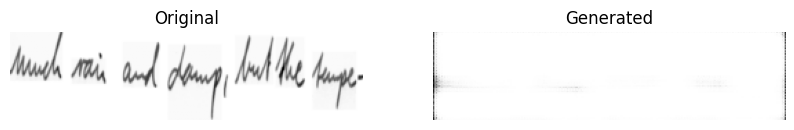

In [49]:
for i, batch in enumerate(test_loader):
    if i >= 1:  # Generate 5 samples
        break
    
    # Get a sample for style reference
    style_image = batch['image'][0]
    text = batch['transcription'][0]
    
    # Generate new handwriting with the same style but different text
    generated = model.generate_handwriting(style_image, "This is a generated sample.")
    
    # Plot the results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(style_image.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Generated")
    plt.imshow(generated.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.savefig(os.path.join(config.results_dir, f"sample_{i}.png"))
    # plt.close()